<a href="https://www.kaggle.com/code/guisira/nlp-disasters-lstm-conv1d-gru?scriptVersionId=92530227" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/glove6b100dtxt/glove.6B.100d.txt
/kaggle/input/twitter-mask/twitter_mask.png


In [2]:
import csv
import string 
import random
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from scipy.stats import linregress
from nltk import corpus
import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.stem.snowball import SnowballStemmer
import seaborn as sns
from collections import Counter
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# %matplotlib inline

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Sentiment Extaction-Analysis EDA 

In [3]:
df_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")

In [4]:
print(df_train.shape)

(7613, 5)


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
df_train = df_train[["id","text","target"]]

In [7]:
df_train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
temp = df_train.groupby('target').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp

,target,text
0,0,4342
1,1,3271


<AxesSubplot:xlabel='target', ylabel='count'>

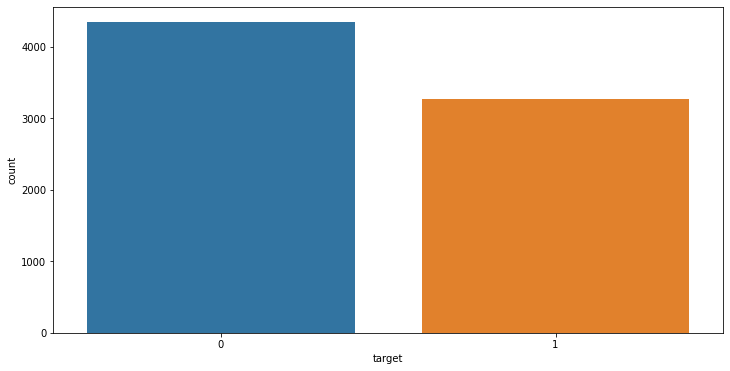

In [9]:
plt.figure(figsize=(12,6))
sns.countplot(x='target',data=df_train)

In [10]:
def clean_text(text) :
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text    

In [11]:
df_train['text'] = df_train['text'].apply(lambda x:clean_text(x))

In [12]:
df_train['temp_list'] = df_train['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in df_train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(10))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,the,3248
1,a,2167
2,in,1971
3,to,1943
4,of,1821
5,and,1410
6,i,1363
7,is,942
8,for,889
9,on,850


In [13]:
def remove_stopword(x):
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    return [word for word in x if not word in set(all_stopwords)]

df_train['temp_list'] = df_train['temp_list'].apply(lambda x:remove_stopword(x))

In [14]:
top = Counter([item for sublist in df_train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:,:]
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Purples')

,Common_words,count
1,amp,298
2,im,294
3,not,293
4,fire,248
5,get,228
6,new,223
7,via,220
8,people,196
9,one,191
10,dont,189


In [15]:
fig = px.treemap(temp, path=['Common_words'], values='count',title='Tree of Most Common Words')
fig.show()

In [16]:
real_disaster = df_train[df_train['target']== 0]
fake_disaster = df_train[df_train['target']== 1]

In [17]:
top = Counter([item for sublist in real_disaster['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words','count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,like,252
1,im,239
2,not,201
3,amp,192
4,new,168
5,get,162
6,dont,139
7,one,126
8,body,112
9,via,99


In [18]:
top = Counter([item for sublist in fake_disaster['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:,:]
temp_negative.columns = ['Common_words','count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,news,132
2,via,121
3,disaster,116
4,california,111
5,suicide,110
6,amp,106
7,people,105
8,police,105
9,killed,93
10,not,92


In [19]:
raw_text = [word for word_list in df_train['temp_list'] for word in word_list]

In [20]:
def words_unique(target,numwords,raw_words):
    '''
    Input:
        segment - Segment category (ex. 'Neutral');
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list  for item in train_data[train_data.segments == segments]['temp_list1']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    allother = []
    for item in df_train[df_train.target != target]['temp_list']:
        for word in item:
            allother .append(word)
    allother  = list(set(allother ))
    
    specificnonly = [x for x in raw_text if x not in allother]
    
    mycounter = Counter()
    
    for item in df_train[df_train.target == target]['temp_list']:
        for word in item:
            mycounter[word] += 1
    keep = list(specificnonly)
    
    for word in list(mycounter):
        if word not in keep:
            del mycounter[word]
    
    Unique_words = pd.DataFrame(mycounter.most_common(numwords), columns = ['words','count'])
    
    return Unique_words

In [21]:
Unique_true= words_unique(1, 20, raw_text)
print("The top 20 unique words in Positive Tweets are:")
Unique_true.style.background_gradient(cmap='Greens')

The top 20 unique words in Positive Tweets are:


,words,count
0,northern,64
1,legionnaires,62
2,debris,50
3,severe,47
4,derailment,40
5,migrants,39
6,investigators,37
7,mosque,35
8,pkk,31
9,detonated,31


In [22]:
fig = px.treemap(Unique_true, path=['words'], values='count',title='Tree Of Unique True Words')
fig.show()

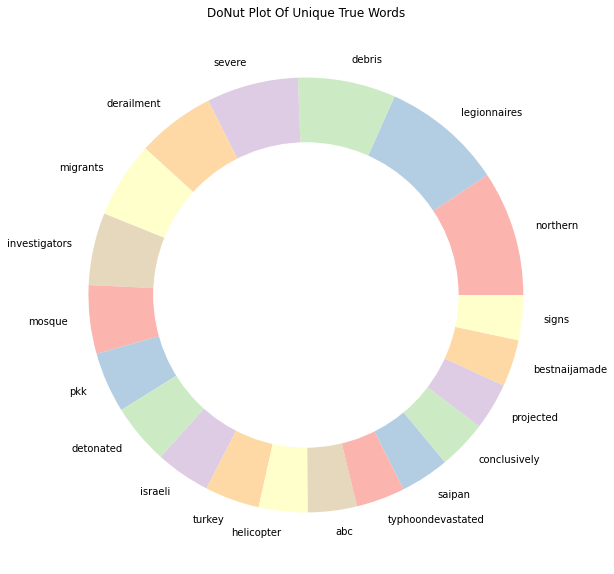

In [23]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_true['count'], labels=Unique_true.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique True Words')
plt.show()

In [24]:
Unique_fake = words_unique(0, 10, raw_text)
print("The top 10 unique words in Negative Tweets are:")
Unique_fake.style.background_gradient(cmap='Reds')

The top 10 unique words in Negative Tweets are:


,words,count
0,lmao,16
1,king,14
2,career,13
3,aftershock,12
4,louis,12
5,edm,11
6,lucky,11
7,complete,11
8,arianagrande,11
9,shall,10


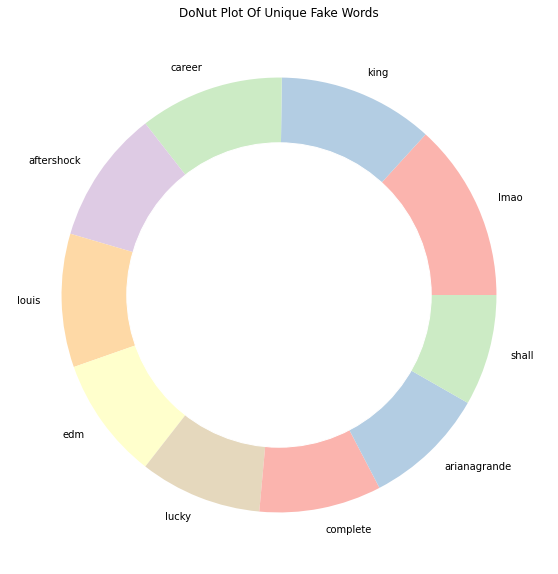

In [25]:
from palettable.colorbrewer.qualitative import Pastel1_7
plt.figure(figsize=(16,10))
my_circle=plt.Circle((0,0), 0.7, color='white')
plt.pie(Unique_fake['count'], labels=Unique_fake.words, colors=Pastel1_7.hex_colors)
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('DoNut Plot Of Unique Fake Words')
plt.show()

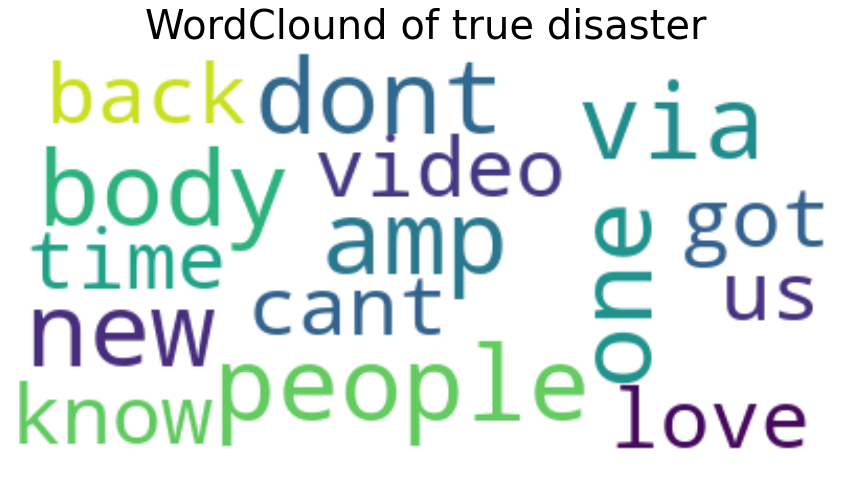

In [26]:
text = " ".join(i for i in temp_positive.Common_words)

# Create and generate a word cloud image:
stopwords = set(STOPWORDS)
more_stopwords = {'u', "im"}
stopwords = stopwords.union(more_stopwords)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stopwords).generate(text)
# Display the generated image:
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordClound of true disaster", fontdict={'size': 40,  'verticalalignment': 'bottom'})
plt.axis("off")
plt.show()

In [27]:
real_disaster

,id,text,target,temp_list
15,23,whats up man,0,"[whats, man]"
16,24,i love fruits,0,"[love, fruits]"
17,25,summer is lovely,0,"[summer, lovely]"
18,26,my car is so fast,0,"[car, fast]"
19,28,what a goooooooaaaaaal,0,[goooooooaaaaaal]
...,...,...,...,...
7581,10833,engineshed great atmosphere at the british lio...,0,"[engineshed, great, atmosphere, british, lion,..."
7582,10834,cramer igers words that wrecked disneys stock...,0,"[cramer, igers, words, wrecked, disneys, stock..."
7584,10837,these boxes are ready to explode exploding kit...,0,"[boxes, ready, explode, exploding, kittens, fi..."
7587,10841,sirens everywhere,0,"[sirens, everywhere]"


In [28]:
real_disaster.head()

,id,text,target,temp_list
15,23,whats up man,0,"[whats, man]"
16,24,i love fruits,0,"[love, fruits]"
17,25,summer is lovely,0,"[summer, lovely]"
18,26,my car is so fast,0,"[car, fast]"
19,28,what a goooooooaaaaaal,0,[goooooooaaaaaal]


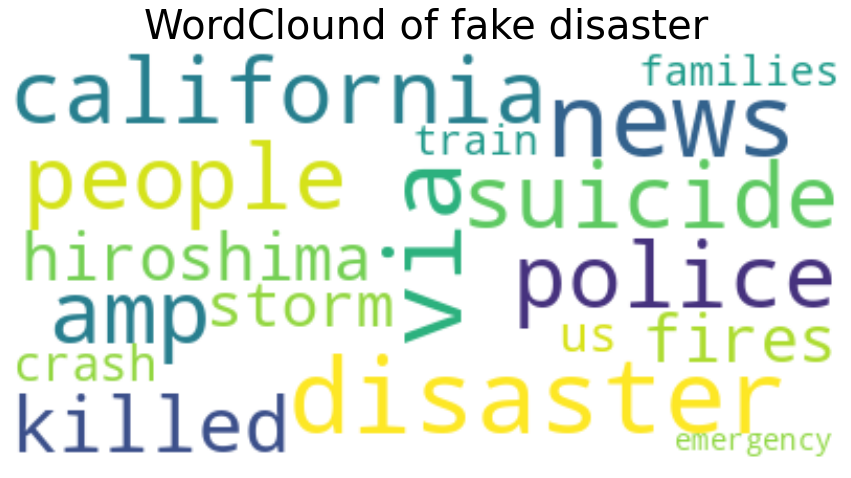

In [29]:
text = " ".join(i for i in temp_negative.Common_words)

# Create and generate a word cloud image:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stopwords).generate(text)
# Display the generated image:
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordClound of fake disaster", fontdict={'size': 40,  'verticalalignment': 'bottom'})
plt.axis("off")
plt.show()

# Prepareration data for create model

## Create function Clean word
Make text lowercase, remove text in square brackets,remove links,remove punctuation and remove words containing numbers.

In [30]:
from nltk import corpus
import re
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords 


SENTIMENT_CSV = "../input/nlp-getting-started/train.csv"
def remove_stopwords(sentence):
    # List of stopwords
    sentence = sentence.lower()
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub('\[.*?\]', '', sentence)
    sentence = re.sub('https?://\S+|www\.\S+', '', sentence)
    sentence = re.sub('<.*?>+', '', sentence)
    sentencet = re.sub('[%s]' % re.escape(string.punctuation), '', sentence)
    sentence = re.sub('\n', '', sentence)
    sentence = re.sub('\w*\d\w*', '', sentence)
    sentence  = sentence.split()
    all_stopwords = stopwords.words('english')
    all_stopwords.remove('not')
    sentence = [word for word in sentence if not word in set(all_stopwords)]
    snow_stemmer = SnowballStemmer(language='english')
    sentence = [snow_stemmer.stem(word) for word in sentence]
    sentence = " ".join(sentence)
        
    return sentence

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Create function read csv

In [31]:
def parse_data_from_file(filename):
    
    sentences = []
    labels = []
    
    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        next(reader)
        for row in reader:
            
            labels.append(int(row[4]))
            sentence = row[3]
            sentence = remove_stopwords(sentence)
            sentences.append(sentence)

        
    return sentences, labels

In [32]:
sentences, labels = parse_data_from_file(SENTIMENT_CSV)

print(f"dataset contains {len(sentences)} examples\n")

print(f"Text of second example should look like this:\n{sentences[0]}\n")
print(f"Text of fourth example should look like this:\n{sentences[3]}")

print(f"\nLabels of last 5 examples should look like this:\n{labels[-5:]}")

dataset contains 7613 examples

Text of second example should look like this:
deed reason earthquak may allah forgiv us

Text of fourth example should look like this:
peopl receiv wildfir evacu order california

Labels of last 5 examples should look like this:
[1, 1, 1, 1, 1]


# Training - Validation Split

In [33]:
x_train, x_val, y_train, y_val = train_test_split(sentences, labels,  
                                                  random_state=1, 
                                                  test_size=0.2, shuffle=True)

In [34]:
print(f"There are {len(x_train)} sentences for training.\n")
print(f"There are {len(y_train)} labels for training.\n")
print(f"There are {len(x_val)} sentences for validation.\n")
print(f"There are {len(y_val)} labels for validation.")

There are 6090 sentences for training.

There are 6090 labels for training.

There are 1523 sentences for validation.

There are 1523 labels for validation.


In [35]:
unique, counts = np.unique(y_train, return_counts=True)
train_result = np.column_stack((unique, counts)) 
print(train_result)

[[   0 3460]
 [   1 2630]]


In [36]:
unique, counts = np.unique(y_val, return_counts=True)
val_result = np.column_stack((unique, counts)) 
print(val_result)

[[  0 882]
 [  1 641]]


## Tokenization - Sequences, truncating and padding

In [37]:
def fit_tokenizer(train_sentences, oov_token):
    
    ### START CODE HERE
    
    # Instantiate the Tokenizer class, passing in the correct values for num_words and oov_token
    tokenizer = Tokenizer(oov_token = oov_token)
    
    # Fit the tokenizer to the training sentences
    tokenizer.fit_on_texts(train_sentences)
    
    ### END CODE HERE
    
    return tokenizer

In [38]:
OOV_TOKEN = "<OOV>"
tokenizer = fit_tokenizer(x_train, OOV_TOKEN)

word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")
print(f"\nindex of word 'dog' should be {word_index['dog']}")

Vocabulary contains 16187 words

<OOV> token included in vocabulary

index of word 'dog' should be 404


In [39]:
def seq_pad_and_trunc(sentences, tokenizer, padding, truncating, maxlen):
    
    ### START CODE HERE
       
    # Convert sentences to sequences
    sequences = tokenizer.texts_to_sequences(sentences)
    
    # Pad the sequences using the correct padding, truncating and maxlen
    pad_trunc_sequences = pad_sequences(sequences, padding= padding, maxlen = maxlen, truncating = truncating)
    
    ### END CODE HERE
    
    return pad_trunc_sequences

In [40]:
EMBEDDING_DIM = 100
MAXLEN = 30
TRUNCATING = 'post'
PADDING = 'post'
train_pad_trunc_seq = seq_pad_and_trunc(x_train, tokenizer, PADDING, TRUNCATING, MAXLEN)
val_pad_trunc_seq = seq_pad_and_trunc(x_val, tokenizer, PADDING, TRUNCATING, MAXLEN)

print(f"Padded and truncated training sequences have shape: {train_pad_trunc_seq.shape}\n")
print(f"Padded and truncated validation sequences have shape: {val_pad_trunc_seq.shape}\n")

Padded and truncated training sequences have shape: (6090, 30)

Padded and truncated validation sequences have shape: (1523, 30)



In [41]:
train_labels = np.array(y_train)
val_labels = np.array(y_val)

## Using pre-defined Embeddings 6b100d

In [42]:
# Define path to file containing the embeddings
GLOVE_FILE = '../input/glove6b100dtxt/glove.6B.100d.txt'

# Initialize an empty embeddings index dictionary
GLOVE_EMBEDDINGS = {}

# Read file and fill GLOVE_EMBEDDINGS with its contents
with open(GLOVE_FILE) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        GLOVE_EMBEDDINGS[word] = coefs

In [43]:
test_word = 'dog'

test_vector = GLOVE_EMBEDDINGS[test_word]

print(f"Vector representation of word {test_word} looks like this:\n\n{test_vector}")

Vector representation of word dog looks like this:

[ 0.30817    0.30938    0.52803   -0.92543   -0.73671    0.63475
  0.44197    0.10262   -0.09142   -0.56607   -0.5327     0.2013
  0.7704    -0.13983    0.13727    1.1128     0.89301   -0.17869
 -0.0019722  0.57289    0.59479    0.50428   -0.28991   -1.3491
  0.42756    1.2748    -1.1613    -0.41084    0.042804   0.54866
  0.18897    0.3759     0.58035    0.66975    0.81156    0.93864
 -0.51005   -0.070079   0.82819   -0.35346    0.21086   -0.24412
 -0.16554   -0.78358   -0.48482    0.38968   -0.86356   -0.016391
  0.31984   -0.49246   -0.069363   0.018869  -0.098286   1.3126
 -0.12116   -1.2399    -0.091429   0.35294    0.64645    0.089642
  0.70294    1.1244     0.38639    0.52084    0.98787    0.79952
 -0.34625    0.14095    0.80167    0.20987   -0.86007   -0.15308
  0.074523   0.40816    0.019208   0.51587   -0.34428   -0.24525
 -0.77984    0.27425    0.22418    0.20164    0.017431  -0.014697
 -1.0235    -0.39695   -0.0056188  0.3

In [44]:
len(GLOVE_EMBEDDINGS)

400000

In [45]:
print(f"Each word vector has shape: {test_vector.shape}")

Each word vector has shape: (100,)


In [46]:
hits = 0
misses = 0
# Prepare embedding matrix
EMBEDDINGS_MATRIX = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = GLOVE_EMBEDDINGS.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        EMBEDDINGS_MATRIX[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 7603 words (8584 misses)


In [47]:
def roc_auc(predictions,target):
    '''
    This methods returns the AUC Score when given the Predictions
    and Labels
    '''
    
    fpr, tpr, thresholds = metrics.roc_curve(target, predictions)
    roc_auc = metrics.auc(fpr, tpr)
    return roc_auc

## Create simple RNN model

In [48]:
def Simple_RNN(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    RNN_model = tf.keras.Sequential([ 
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, input_length=MAXLEN, weights=[EMBEDDINGS_MATRIX], trainable=False),
        tf.keras.layers.SimpleRNN(64),
        tf.keras.layers.Dense(1, activation='sigmoid'),
])
    RNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return RNN_model

In [49]:
RNN_model = Simple_RNN(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)
RNN_model.summary()

2022-04-09 10:41:55.013305: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 30, 100)           1618800   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                10560     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,629,425
Trainable params: 10,625
Non-trainable params: 1,618,800
_________________________________________________________________


In [50]:
RNN_model.fit(x = train_pad_trunc_seq, y = train_labels, epochs = 30, batch_size=64)

2022-04-09 10:41:55.544742: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
96/96 [==============================] - 4s 22ms/step - loss: 0.6054 - accuracy: 0.6752
Epoch 2/30
96/96 [==============================] - 2s 23ms/step - loss: 0.5375 - accuracy: 0.7547
Epoch 3/30
96/96 [==============================] - 2s 22ms/step - loss: 0.5111 - accuracy: 0.7791
Epoch 4/30
96/96 [==============================] - 2s 23ms/step - loss: 0.4932 - accuracy: 0.7846
Epoch 5/30
96/96 [==============================] - 2s 24ms/step - loss: 0.4850 - accuracy: 0.7924
Epoch 6/30
96/96 [==============================] - 2s 23ms/step - loss: 0.4685 - accuracy: 0.7997
Epoch 7/30
96/96 [==============================] - 2s 23ms/step - loss: 0.4503 - accuracy: 0.8113
Epoch 8/30
96/96 [==============================] - 2s 23ms/step - loss: 0.4542 - accuracy: 0.8041
Epoch 9/30
96/96 [==============================] - 2s 23ms/step - loss: 0.4392 - accuracy: 0.8166
Epoch 10/30
96/96 [==============================] - 2s 24ms/step - loss: 0.4303 - accuracy: 0.8218
Epoch 11/

In [51]:
scores = RNN_model.predict(val_pad_trunc_seq)
scores = np.around(scores, decimals=0)
print("Accuracy :", metrics.accuracy_score(val_labels,scores))
print("F1_Score :", metrics.f1_score(val_labels,scores))
print("Auc: %.2f%%" % (roc_auc(scores,val_labels)))

Accuracy : 0.7104399212081418
F1_Score : 0.6792727272727274
Auc: 0.71%


In [52]:
scores_model = []
scores_model.append({'Model': 'SimpleRNN','AUC_Score': roc_auc(scores,val_labels),'Accuracy_Score': metrics.accuracy_score(val_labels,scores),
                    'F1_Score': metrics.f1_score(val_labels,scores)})

# LSTM

In [53]:
def LSTM(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    LSTM_model = tf.keras.Sequential([ 
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, input_length=MAXLEN, weights=[EMBEDDINGS_MATRIX], trainable=False),
        tf.keras.layers.LSTM(64),
        tf.keras.layers.Dense(1, activation='sigmoid'),
])
    LSTM_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return LSTM_model

In [54]:
LSTM_model = LSTM(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 30, 100)           1618800   
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,661,105
Trainable params: 42,305
Non-trainable params: 1,618,800
_________________________________________________________________


In [55]:
LSTM_model.fit(x = train_pad_trunc_seq, y = train_labels, epochs = 30, batch_size=64)

Epoch 1/30
96/96 [==============================] - 6s 34ms/step - loss: 0.5543 - accuracy: 0.7227
Epoch 2/30
96/96 [==============================] - 3s 34ms/step - loss: 0.4827 - accuracy: 0.7833
Epoch 3/30
96/96 [==============================] - 3s 35ms/step - loss: 0.4596 - accuracy: 0.7972
Epoch 4/30
96/96 [==============================] - 4s 42ms/step - loss: 0.4483 - accuracy: 0.8053
Epoch 5/30
96/96 [==============================] - 3s 35ms/step - loss: 0.4285 - accuracy: 0.8182
Epoch 6/30
96/96 [==============================] - 3s 34ms/step - loss: 0.4156 - accuracy: 0.8222
Epoch 7/30
96/96 [==============================] - 3s 35ms/step - loss: 0.4014 - accuracy: 0.8304
Epoch 8/30
96/96 [==============================] - 3s 34ms/step - loss: 0.3764 - accuracy: 0.8415
Epoch 9/30
96/96 [==============================] - 3s 35ms/step - loss: 0.3638 - accuracy: 0.8489
Epoch 10/30
96/96 [==============================] - 3s 34ms/step - loss: 0.3407 - accuracy: 0.8634
Epoch 11/

In [56]:
scores = LSTM_model.predict(val_pad_trunc_seq)
scores = np.around(scores, decimals=0)
print("Accuracy :", metrics.accuracy_score(val_labels,scores))
print("F1_Score :", metrics.f1_score(val_labels,scores))
print("Auc: %.2f%%" % (roc_auc(scores,val_labels)))

Accuracy : 0.7688772160210111
F1_Score : 0.7061769616026712
Auc: 0.75%


In [57]:
scores_model.append({'Model': 'LSTM','AUC_Score': roc_auc(scores,val_labels),'Accuracy_Score': metrics.accuracy_score(val_labels,scores),
                    'F1_Score': metrics.f1_score(val_labels,scores)})

## GRU's

In [58]:
def GRU(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    GRU_model = tf.keras.Sequential([ 
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, input_length=MAXLEN, weights=[EMBEDDINGS_MATRIX], trainable=False),
        tf.keras.layers.GRU(64),
        tf.keras.layers.Dense(1, activation='sigmoid'),
])
    GRU_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return GRU_model

In [59]:
GRU_model = GRU(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)
GRU_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 30, 100)           1618800   
_________________________________________________________________
gru (GRU)                    (None, 64)                31872     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,650,737
Trainable params: 31,937
Non-trainable params: 1,618,800
_________________________________________________________________


In [60]:
GRU_model.fit(x = train_pad_trunc_seq, y = train_labels, epochs = 30, batch_size=64)

Epoch 1/30
96/96 [==============================] - 6s 40ms/step - loss: 0.6721 - accuracy: 0.5906
Epoch 2/30
96/96 [==============================] - 4s 41ms/step - loss: 0.5000 - accuracy: 0.7721
Epoch 3/30
96/96 [==============================] - 4s 41ms/step - loss: 0.4733 - accuracy: 0.7915
Epoch 4/30
96/96 [==============================] - 4s 44ms/step - loss: 0.4500 - accuracy: 0.8062
Epoch 5/30
96/96 [==============================] - 4s 44ms/step - loss: 0.4428 - accuracy: 0.8090
Epoch 6/30
96/96 [==============================] - 5s 48ms/step - loss: 0.4230 - accuracy: 0.8182
Epoch 7/30
96/96 [==============================] - 4s 40ms/step - loss: 0.4076 - accuracy: 0.8310
Epoch 8/30
96/96 [==============================] - 4s 43ms/step - loss: 0.3930 - accuracy: 0.8356
Epoch 9/30
96/96 [==============================] - 4s 40ms/step - loss: 0.3753 - accuracy: 0.8468
Epoch 10/30
96/96 [==============================] - 4s 41ms/step - loss: 0.3579 - accuracy: 0.8539
Epoch 11/

In [61]:
scores = GRU_model.predict(val_pad_trunc_seq)
scores = np.around(scores, decimals=0)
print("Accuracy :", metrics.accuracy_score(val_labels,scores))
print("F1_Score :", metrics.f1_score(val_labels,scores))
print("Auc: %.2f%%" % (roc_auc(scores,val_labels)))

Accuracy : 0.7688772160210111
F1_Score : 0.6939130434782609
Auc: 0.75%


In [62]:
scores_model.append({'Model': 'GRU','AUC_Score': roc_auc(scores,val_labels),'Accuracy_Score': metrics.accuracy_score(val_labels,scores),
                    'F1_Score': metrics.f1_score(val_labels,scores)})

## Bidirectional LSTM

In [63]:
def Bi_LSTM(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    bilstm_model = tf.keras.Sequential([ 
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, input_length=MAXLEN, weights=[EMBEDDINGS_MATRIX], trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)), 
        tf.keras.layers.Dense(1, activation='sigmoid'),
])
    bilstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return bilstm_model

In [64]:
bilstm_model = Bi_LSTM(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)
bilstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 30, 100)           1618800   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               84480     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,703,409
Trainable params: 84,609
Non-trainable params: 1,618,800
_________________________________________________________________


In [65]:
bilstm_model.fit(x = train_pad_trunc_seq, y = train_labels, epochs = 30, batch_size=64)

Epoch 1/30
96/96 [==============================] - 11s 70ms/step - loss: 0.5257 - accuracy: 0.7430
Epoch 2/30
96/96 [==============================] - 6s 62ms/step - loss: 0.4662 - accuracy: 0.7867
Epoch 3/30
96/96 [==============================] - 6s 63ms/step - loss: 0.4418 - accuracy: 0.8007
Epoch 4/30
96/96 [==============================] - 6s 62ms/step - loss: 0.4276 - accuracy: 0.8099
Epoch 5/30
96/96 [==============================] - 6s 65ms/step - loss: 0.4104 - accuracy: 0.8215
Epoch 6/30
96/96 [==============================] - 7s 69ms/step - loss: 0.3931 - accuracy: 0.8292
Epoch 7/30
96/96 [==============================] - 6s 62ms/step - loss: 0.3677 - accuracy: 0.8432
Epoch 8/30
96/96 [==============================] - 6s 63ms/step - loss: 0.3451 - accuracy: 0.8537
Epoch 9/30
96/96 [==============================] - 6s 62ms/step - loss: 0.3322 - accuracy: 0.8604
Epoch 10/30
96/96 [==============================] - 6s 67ms/step - loss: 0.3059 - accuracy: 0.8747
Epoch 11

In [66]:
scores = bilstm_model.predict(val_pad_trunc_seq)
scores = np.around(scores, decimals=0)
print("Accuracy :", metrics.accuracy_score(val_labels,scores))
print("F1_Score :", metrics.f1_score(val_labels,scores))
print("Auc: %.2f%%" % (roc_auc(scores,val_labels)))

Accuracy : 0.7347340774786605
F1_Score : 0.6726094003241492
Auc: 0.72%


In [67]:
scores_model.append({'Model': 'Bi-directional','AUC_Score': roc_auc(scores,val_labels),'Accuracy_Score': metrics.accuracy_score(val_labels,scores),
                    'F1_Score': metrics.f1_score(val_labels,scores)})

## Conv1D layer

In [68]:
def CNN(vocab_size, embedding_dim, maxlen, embeddings_matrix):
    CNN_model = tf.keras.Sequential([ 
        # This is how you need to set the Embedding layer when using pre-trained embeddings
        tf.keras.layers.Embedding(VOCAB_SIZE+1, EMBEDDING_DIM, input_length=MAXLEN, weights=[EMBEDDINGS_MATRIX], trainable=False),
        tf.keras.layers.Conv1D(64, 5, activation='relu'),
        tf.keras.layers.GlobalMaxPooling1D(),
        tf.keras.layers.Dense(1, activation='sigmoid'),
])
    CNN_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return CNN_model

In [69]:
CNN_model = CNN(VOCAB_SIZE, EMBEDDING_DIM, MAXLEN, EMBEDDINGS_MATRIX)
CNN_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 30, 100)           1618800   
_________________________________________________________________
conv1d (Conv1D)              (None, 26, 64)            32064     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 1,650,929
Trainable params: 32,129
Non-trainable params: 1,618,800
_________________________________________________________________


In [70]:
CNN_model.fit(x = train_pad_trunc_seq, y = train_labels, epochs = 30, batch_size=64)

Epoch 1/30
96/96 [==============================] - 1s 8ms/step - loss: 0.5339 - accuracy: 0.7386
Epoch 2/30
96/96 [==============================] - 1s 8ms/step - loss: 0.4368 - accuracy: 0.8071
Epoch 3/30
96/96 [==============================] - 1s 8ms/step - loss: 0.3902 - accuracy: 0.8322
Epoch 4/30
96/96 [==============================] - 1s 8ms/step - loss: 0.3479 - accuracy: 0.8609
Epoch 5/30
96/96 [==============================] - 1s 11ms/step - loss: 0.3149 - accuracy: 0.8772
Epoch 6/30
96/96 [==============================] - 1s 12ms/step - loss: 0.2761 - accuracy: 0.8992
Epoch 7/30
96/96 [==============================] - 1s 8ms/step - loss: 0.2459 - accuracy: 0.9177
Epoch 8/30
96/96 [==============================] - 1s 8ms/step - loss: 0.2160 - accuracy: 0.9351
Epoch 9/30
96/96 [==============================] - 1s 8ms/step - loss: 0.1871 - accuracy: 0.9509
Epoch 10/30
96/96 [==============================] - 1s 8ms/step - loss: 0.1662 - accuracy: 0.9585
Epoch 11/30
96/96

In [71]:
scores = CNN_model.predict(val_pad_trunc_seq)
scores = np.around(scores, decimals=0)
print("Accuracy :", metrics.accuracy_score(val_labels,scores))
print("F1_Score :", metrics.f1_score(val_labels,scores))
print("Auc: %.2f%%" % (roc_auc(scores,val_labels)))

Accuracy : 0.7583716349310571
F1_Score : 0.7012987012987012
Auc: 0.75%


In [72]:
scores_model.append({'Model': '1D Convolution Layer','AUC_Score': roc_auc(scores,val_labels),'Accuracy_Score': metrics.accuracy_score(val_labels,scores),
                    'F1_Score': metrics.f1_score(val_labels,scores)})

In [73]:
# Visualization of Results obtained from various Deep learning models
results = pd.DataFrame(scores_model).sort_values(by='AUC_Score',ascending=False)
results.style.background_gradient(cmap='Blues')

,Model,AUC_Score,Accuracy_Score,F1_Score
1,LSTM,0.753989,0.768877,0.706177
2,GRU,0.748874,0.768877,0.693913
4,1D Convolution Layer,0.746837,0.758372,0.701299
3,Bi-directional,0.722806,0.734734,0.672609
0,SimpleRNN,0.712914,0.710440,0.679273
